In [1]:
import elasticsearch
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil.relativedelta import relativedelta
%matplotlib inline 
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

#### Recuperation des données

In [2]:
hosts = [{"host": 'localhost', "port": 9200}]
database = elasticsearch.Elasticsearch(hosts=hosts)

In [3]:
def get_datas(database):
    query = {
        "query": {
            "match_all": {}
        }
    }

    result = database.search(
        index="index_activity",
        size=1000,
        body= query
    )
    
    
    activities = result['hits']['hits']
    activities_json = [ activity.get("_source") for activity in activities]
    activities_df = pd.DataFrame(activities_json)
    activities_df = activities_df.drop(columns=['py/object', 'segment_efforts'])
    
    segments_json = [ segment for activity in activities_json for segment in activity.get("segment_efforts")]
    segments_df = pd.DataFrame(segments_json)
    segments_df = segments_df.drop(columns=['py/object'])
    
    return activities_df, segments_df

activities_df, segments_df = get_datas(database)

In [4]:
print(activities_df.shape)
print(segments_df.shape)

(211, 17)
(1992, 16)


#### Activités ainsi que les segments Strava composant chacune de ces activitées


Certaines activités ne semblent pas avoir de segments => Refonte de segments Strava , cela semble OK 


In [5]:
len(segments_df['activity_id'].unique())

202

In [6]:
len(activities_df['id'].unique())

211

In [7]:
for id_activity in activities_df['id'].unique():
    if id_activity not in segments_df['activity_id'].unique():
        print(id_activity)

2104915553
3867618242
3793647041
3791009530
2923534509
2749334701
2545454637
2526054334
2215374863


###  Analyse des données

In [8]:
segments_df.head()

,id,activity_id,athlete_id,name,type,elapsed_time,moving_time,start_date_local,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate
0,27180136,4801436758,10944546,Kent Rd Climb to Sprint Banner (Zwift Insider ...,VirtualRide,176,176,2021-02-17T13:36:00Z,1137.3,81.4,183.4,2.6,7.0,0,149.4,156.0
1,21748007,4801436758,10944546,Yorkshire Sprint Reverse,VirtualRide,63,63,2021-02-17T13:37:53Z,394.3,79.9,182.9,2.1,5.7,0,153.4,156.0
2,27207377,4801436758,10944546,Finishing Straightaway (Zwift Insider verified),VirtualRide,99,99,2021-02-17T13:40:47Z,611.1,78.4,192.3,3.3,10.2,0,156.7,162.0
3,27180001,4801436758,10944546,Otley Rd Climb (Zwift Insider verified),VirtualRide,285,285,2021-02-17T13:43:02Z,1641.6,75.5,204.1,3.4,6.6,0,164.7,172.0
4,20837686,4801436758,10944546,Beckwithshaw to Penny Pot - Fulgaz,VirtualRide,256,256,2021-02-17T13:51:25Z,2323.4,75.5,189.3,-1.1,10.9,0,167.3,177.0


In [9]:
segments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1992 non-null   int64  
 1   activity_id         1992 non-null   int64  
 2   athlete_id          1992 non-null   int64  
 3   name                1992 non-null   object 
 4   type                1992 non-null   object 
 5   elapsed_time        1992 non-null   int64  
 6   moving_time         1992 non-null   int64  
 7   start_date_local    1992 non-null   object 
 8   distance            1992 non-null   float64
 9   average_cadence     1103 non-null   float64
 10  average_watts       1992 non-null   float64
 11  average_grade       1992 non-null   float64
 12  maximum_grade       1992 non-null   float64
 13  climb_category      1992 non-null   int64  
 14  average_heart_rate  1151 non-null   float64
 15  max_heart_rate      1151 non-null   float64
dtypes: flo

* Variables numériques hormis **name , type et start_date_local** 
* **average_heart_rate et max_heart_rate** comportent de nombreuses infos manquantes , activités réalisés sans capteur cardiaque

In [10]:
segments_df['type'].value_counts()

VirtualRide    1078
Ride            914
Name: type, dtype: int64

In [11]:
segments_df['name'].value_counts()

Col du Chateau d'eau          30
Col du chateau d'eau court    30
Champs-Élysées                29
Rien à foutre                 28
À fond jusqu'au poteau        28
                              ..
2 bend 2                       1
alpe d'huez                    1
la pancarte                    1
Start to bend 21               1
route de Lartigue vers 113     1
Name: name, Length: 486, dtype: int64

In [12]:
segments_df['start_date_local'] = pd.to_datetime(segments_df['start_date_local'])

In [13]:
segments_df.describe()

,id,activity_id,athlete_id,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate
count,1.992000e+03,1.992000e+03,1992.0,1992.000000,1992.000000,1992.000000,1103.000000,1992.000000,1992.000000,1992.000000,1992.000000,1151.000000,1151.000000
mean,1.561883e+07,3.204345e+09,10944546.0,663.692269,648.585341,3375.957264,80.492747,175.777410,3.158534,9.989608,0.431727,155.118766,164.880104
std,6.362145e+06,8.779137e+08,0.0,1119.309824,1113.859167,5495.900131,8.098743,58.110394,3.873976,10.414700,1.145979,22.364925,23.986943
min,1.731538e+06,1.597381e+09,10944546.0,14.000000,14.000000,64.000000,43.000000,18.100000,-8.500000,-2.900000,0.000000,45.500000,81.000000
25%,1.126710e+07,2.509084e+09,10944546.0,131.750000,125.000000,580.000000,75.200000,136.900000,0.000000,4.275000,0.000000,149.550000,161.000000
50%,1.732952e+07,3.259840e+09,10944546.0,243.000000,228.500000,1190.370000,81.100000,182.600000,2.000000,8.300000,0.000000,159.900000,171.000000
75%,2.058558e+07,4.055624e+09,10944546.0,664.000000,642.250000,4248.025000,86.100000,205.125000,6.600000,12.500000,0.000000,168.200000,179.000000
max,2.720786e+07,4.801437e+09,10944546.0,15378.000000,15372.000000,89053.700000,111.600000,741.400000,22.500000,193.800000,5.000000,187.900000,196.000000


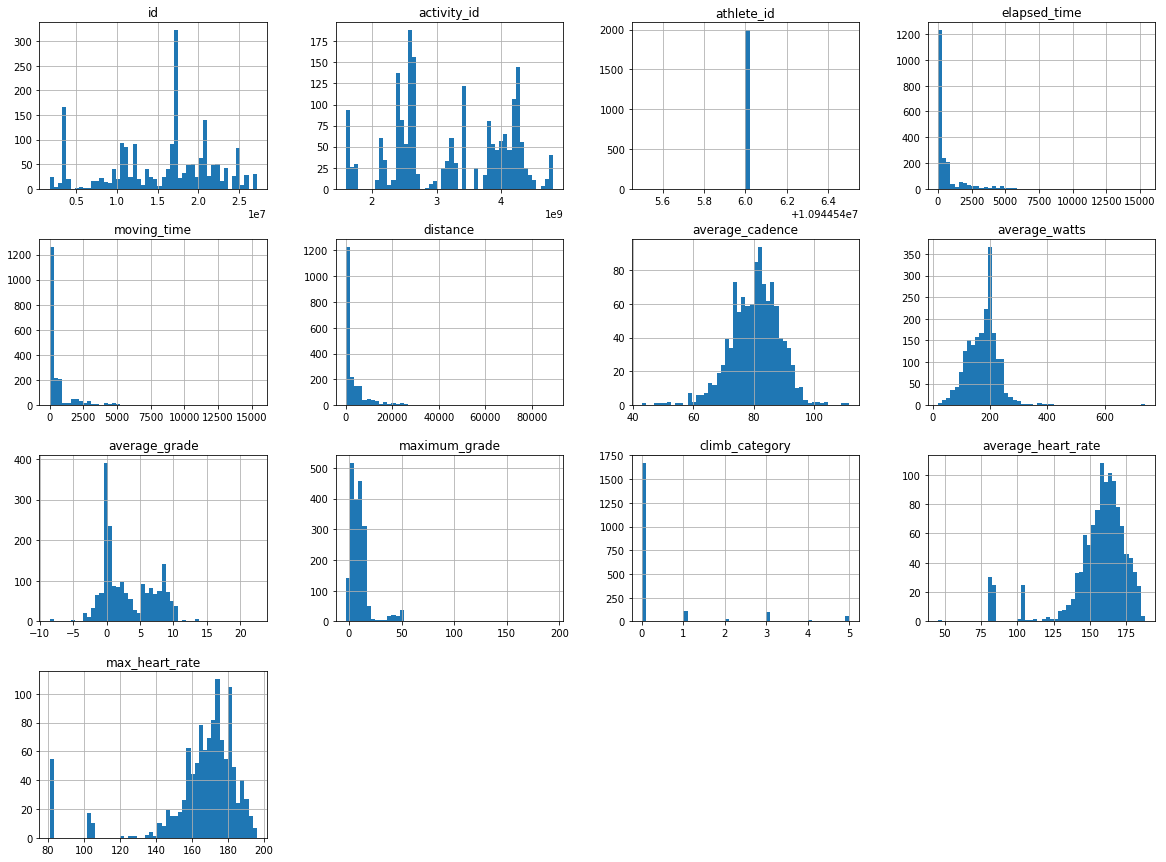

In [14]:
segments_df.hist(bins=50, figsize=(20,15))
plt.show()

* elapsed_time / distance , beaucoup de valeurs abérantes
* Pareil pour maximum_grade avec des % moyen de plus de 30% est ce que toute la donnée est corrompue ?
* Voir aussi pour le heart_rate avec des valeurs a moins de 50...

####  Maximum_grade

Bien que l'information sur le denivelé maximum ne soit pas forcement utile dans le modele , on regarde quand meme ces valeurs extremes...

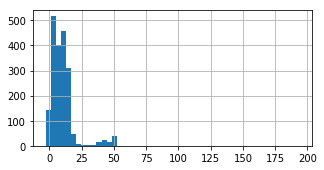

In [15]:
segments_df['maximum_grade'].hist(bins=50, figsize=(5,2.5))
plt.show()

In [16]:
huge_max_grade = segments_df.loc[segments_df['maximum_grade'] > 50]
huge_max_grade.shape

(5, 16)

In [17]:
huge_max_grade['maximum_grade']

333      50.3
1027     56.6
1035    193.8
1146     50.3
1183     50.3
Name: maximum_grade, dtype: float64

On peut imaginer que sur 1m , bien que cela semble énorme , il est possible d'avoir 50% de denivelé , par contre on enleve celui avec 193% de maximum grade

In [18]:
index_to_remove = huge_max_grade.loc[huge_max_grade['maximum_grade'] == 193.8].index[0]
index_to_remove

1035

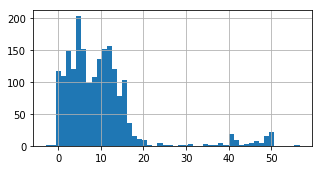

In [19]:
segments_df = segments_df.drop(index_to_remove)
segments_df['maximum_grade'].hist(bins=50, figsize=(5,2.5))
plt.show()


In [20]:
segments_df.shape

(1991, 16)

####  Segments en double dans la meme activité / Segments regroupant d'autres segments

* segments en double dans la meme activité... ( ex : https://www.strava.com/activities/3198007867) **BUG STRAVA**

In [21]:
segments_double = segments_df[segments_df.duplicated()]
segments_double.shape

(9, 16)

In [22]:
segments_double.head()

,id,activity_id,athlete_id,name,type,elapsed_time,moving_time,start_date_local,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate
1137,16784833,3259834962,10944546,Epic KOM,VirtualRide,1831,1831,2020-04-05 18:54:45+00:00,9410.5,84.2,216.1,3.9,9.0,3,NaN,NaN
1197,19171748,3198007867,10944546,Rising Empire,VirtualRide,3115,2981,2020-03-19 17:38:53+00:00,20768.1,76.3,157.6,0.0,16.9,0,NaN,NaN
1199,19171695,3198007867,10944546,Rising Empire Pens to Banner,VirtualRide,3065,2931,2020-03-19 17:39:42+00:00,20546.5,76.4,158.1,-0.0,16.6,0,NaN,NaN
1201,19141090,3198007867,10944546,NYC KOM,VirtualRide,386,386,2020-03-19 17:56:33+00:00,1367.3,80.7,209.8,6.4,17.9,1,NaN,NaN
1203,19141092,3198007867,10944546,NYC KOM Reverse,VirtualRide,319,319,2020-03-19 18:17:21+00:00,1145.1,80.0,195.3,5.9,15.6,0,NaN,NaN


In [23]:
segments_double_index = segments_double.index
segments_double_index

Int64Index([1137, 1197, 1199, 1201, 1203, 1210, 1218, 1220, 1222], dtype='int64')

In [24]:
segments_df = segments_df.drop(segments_double_index)
segments_df.shape

(1982, 16)

In [25]:
segments_df segments_df.reset_index(drop=True)

,id,activity_id,athlete_id,name,type,elapsed_time,moving_time,start_date_local,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate
0,27180136,4801436758,10944546,Kent Rd Climb to Sprint Banner (Zwift Insider ...,VirtualRide,176,176,2021-02-17 13:36:00+00:00,1137.3,81.4,183.4,2.6,7.0,0,149.4,156.0
1,21748007,4801436758,10944546,Yorkshire Sprint Reverse,VirtualRide,63,63,2021-02-17 13:37:53+00:00,394.3,79.9,182.9,2.1,5.7,0,153.4,156.0
2,27207377,4801436758,10944546,Finishing Straightaway (Zwift Insider verified),VirtualRide,99,99,2021-02-17 13:40:47+00:00,611.1,78.4,192.3,3.3,10.2,0,156.7,162.0
3,27180001,4801436758,10944546,Otley Rd Climb (Zwift Insider verified),VirtualRide,285,285,2021-02-17 13:43:02+00:00,1641.6,75.5,204.1,3.4,6.6,0,164.7,172.0
4,20837686,4801436758,10944546,Beckwithshaw to Penny Pot - Fulgaz,VirtualRide,256,256,2021-02-17 13:51:25+00:00,2323.4,75.5,189.3,-1.1,10.9,0,167.3,177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,17352629,2162747048,10944546,Alpe du Zwift Bend 7 to 6,VirtualRide,446,446,2019-02-20 14:27:11+00:00,1160.4,79.4,167.7,7.8,12.1,1,NaN,NaN
1978,17352647,2162747048,10944546,Alpe du Zwift Bend 6 to 5,VirtualRide,181,181,2019-02-20 14:34:37+00:00,522.8,80.4,159.1,6.6,10.3,0,NaN,NaN
1979,17352657,2162747048,10944546,Alpe du Zwift Bend 5 to 4,VirtualRide,173,173,2019-02-20 14:37:38+00:00,453.9,81.5,181.1,8.5,11.9,0,NaN,NaN
1980,17352666,2162747048,10944546,Alpe du Zwift Bend 4 to 3,VirtualRide,334,334,2019-02-20 14:40:31+00:00,860.9,76.3,175.9,8.4,14.3,0,NaN,NaN


### Vertical Drop Algo

In [ ]:
columns = ['elapsed_time','distance','average_grade']
data = segments_df[columns]
data.head(5)

In [ ]:
train_set , test_set = train_test_split(data, test_size=0.1, random_state=42)

y_train = train_set["elapsed_time"]
X_train = train_set.drop("elapsed_time", axis=1)
y_test  = test_set["elapsed_time"]
X_test = test_set.drop("elapsed_time", axis=1)


print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

In [ ]:
X_train

In [ ]:
sns.displot(y_train)

In [ ]:
sns.displot(np.log(y_train))

In [ ]:
y_train_log = np.log(y_train)
y_train_log

In [ ]:
reg = LinearRegression().fit(X_train,y_train_log)
y_pred_log = reg.predict(X_test)

In [ ]:
naive_mae = mean_absolute_error(y_test,np.exp(y_pred_log))
naive_mape = mean_absolute_percentage_error(y_test, np.exp(y_pred_log))
print(f'naive_mae : {naive_mae}')
print(f'naive_mape: {naive_mape}')

In [ ]:
query = {
    "query": {
        "match": {
            "_id": 2787335981548134218
        }
    }
}

result = database.search(
    index="index_route",
    size=1000,
    body= query
)

route_alpe = result['hits']['hits'][0]['_source']
segments_alpe = route_alpe.get("segmentation")
segments_alpe_df = pd.DataFrame(segments_alpe)
segments_alpe_df

In [ ]:
segments_alpe_df = segments_alpe_df.rename(columns={'vertical_drop':'average_grade'})
segments_alpe_df

In [ ]:
segments_alpe_df[['distance','average_grade']]

In [ ]:
alpe_pred = reg.predict(segments_alpe_df[['distance','average_grade']])
elapsed_time = relativedelta(seconds=(np.exp(alpe_pred)).sum())

In [ ]:
hour = int(elapsed_time.hours)
minutes = int(elapsed_time.minutes)
seconds = int(elapsed_time.seconds)
print(f'Prediction {hour}h{minutes}m{seconds}sec')

In [ ]:
np.exp(alpe_pred)